In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_images(generated_images, n_rows=1, n_cols=10):
    """
    Plot the images in a 1x10 grid
    :param generated_images:
    :return:
    """
    f, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    ax = ax.flatten()
    for i in range(n_rows*n_cols):
        ax[i].imshow(generated_images[i, :, :], cmap='gray')
        ax[i].axis('off')
    return f, ax


In [3]:
class GenerateSamplesCallback(tf.keras.callbacks.Callback):
    """
    Callback to generate images from the generator model at the end of each epoch
    Uses the same noise vector to generate images at each epoch, so that the images can be compared over time
    """
    def __init__(self, generator, noise):
        self.generator = generator
        self.noise = noise

    def on_epoch_end(self, epoch, logs=None):
        if not os.path.exists("generated_images"):
            os.mkdir("generated_images")
        generated_images = self.generator(self.noise, training=False)
        generated_images = generated_images.numpy()
        generated_images = generated_images*127.5 + 127.5
        generated_images = generated_images.reshape((10, 28, 28))
        # plot images using matplotlib
        plot_images(generated_images)
        plt.savefig(os.path.join("generated_images", f"generated_images_{epoch}.png"))
        # close the plot to free up memory
        plt.close()

In [4]:
def build_discriminator():
    """
    The discriminator model takes an image input with a shape of (28, 28, 1) and outputs a single
    value that indicates the probability of the input image being real or fake.

    Model Architecture:
    1. Conv2D layer with 16 filters, kernel size of (5, 5), strides of (2, 2), and padding set to 'same'.
    2. LeakyReLU activation function (default parameters)
    3. Dropout layer with a rate of 0.3.
    4. Conv2D layer with 32 filters, kernel size of (5, 5), strides of (2, 2), and padding set to 'same'.
    5. LeakyReLU activation function (default parameters)
    6. Dropout layer with a rate of 0.3.
    7. Flatten layer to convert the feature maps into a 1D array.
    8. Dense layer with 1 output neuron.

Returns:
    model (tf.keras.models.Sequential): A TensorFlow Keras Sequential model representing the discriminator.
    :return:
    """
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(28, 28, 1)))  # 28x28 RGB images
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=1))

    return model

In [5]:
def build_generator():
    """
    The generator model takes a 100-dimensional noise vector as input and outputs a generated
    image with a shape of (28, 28, 1).

    Model Architecture:
    1. Dense layer with 7 * 7 * 8 (392) neurons and no bias, input shape of (100,).
    2. Batch normalization layer, default params
    3. LeakyReLU activation function with default params
    4. Reshape layer to convert the 1D array into a 3D feature map with a shape of (7, 7, 8).
    5. Conv2DTranspose (deconvolution) layer with 8 filters, kernel size of (5, 5), strides of (1, 1)
    6. Batch normalization layer.
    7. LeakyReLU activation function with default params
    8. Conv2DTranspose (deconvolution) layer with 16 filters, kernel size of (5, 5), strides of (2, 2)
    9. Batch normalization layer.
    10. LeakyReLU activation function with default params
    11. Conv2DTranspose (deconvolution) layer with 1 filter, kernel size of (5, 5), strides of (2, 2), with tanh activation included

    Note: For all Conv2DTranspose, use padding='same' and use_bias=False.

    Returns:
        model (tf.keras.models.Sequential): A TensorFlow Keras Sequential model representing the generator.
    """
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.Input(shape=(100,)))
    model.add(tf.keras.layers.Dense(units=392, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape(target_shape=(7, 7, 8)))
    model.add(tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [6]:
class DCGAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        """
        This method takes a batch of real images (data) and generates fake images using the generator model.
        It then computes the loss for both generator and discriminator models and updates the model weights
        using their respective optimizers.

        By implementing this method, you are overriding the default train_step method of the tf.keras.Model class.
        This allows us to train a GAN using model.fit()

        You can adapt the train_step function from the tensorflow DCGAN tutorial
        https://www.tensorflow.org/tutorials/generative/dcgan

        However, You must make the following changes (IMPORTANT!):
        - Instead of using a normal distribution to generate the noise vector, use a uniform distribution (default params in tensorflow)
        - Instead of separately calculating the discriminator loss for real and fake images and adding them together,
          combine the real and fake images into a batch, label them real and fake, and calculate the loss on the entire batch.
          (This is equivalent to doing it separately as done in the tutorial, and giving each 0.5 weight), either one should pass the tests.

        Args:
            data: a batch of real images

        Returns:
            dict[str, tf.Tensor]: A dictionary containing the generator loss ('g_loss') and
                discriminator loss ('d_loss') for the current training step.
        """
        batch_size = tf.shape(data)[0]
        # TRAINING CODE START HERE
        noise = tf.random.uniform([batch_size, 100])
        
        with tf.GradientTape(persistent=True) as tape:
            generated_image = self.generator(noise, training=True)

            real_output = self.discriminator(data, training=True)
            fake_output = self.discriminator(generated_image, training=True)
            combined_output = tf.concat([real_output, fake_output], axis=0)
            labels = tf.concat([tf.ones_like(real_output), tf.zeros_like(fake_output)], axis=0)
            g_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)
            d_loss = self.loss_fn(labels,combined_output)

            gradients_of_generator = tape.gradient(g_loss, self.generator.trainable_variables)
            gradients_of_discriminator = tape.gradient(d_loss, self.discriminator.trainable_variables)

        self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        # TRAINING CODE END HERE
        return {"d_loss": d_loss, "g_loss": g_loss}

In [7]:
def train_dcgan_mnist():
    tf.keras.utils.set_random_seed(5368)
    # load mnist
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # the images are in the range [0, 255], we need to rescale them to [-1, 1]
    x_train = (x_train - 127.5) / 127.5
    x_train = x_train[..., tf.newaxis].astype(np.float32)

    # plot 10 random images
    example_images = x_train[:10]*127.5 + 127.5
    plot_images(example_images)

    plt.savefig("real_images.png")


    # build the discriminator and the generator
    discriminator = build_discriminator()
    generator = build_generator()


    # build the DCGAN
    dcgan = DCGAN(discriminator=discriminator, generator=generator)

    # compile the DCGAN
    dcgan.compile(d_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  g_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True))

    callbacks = [GenerateSamplesCallback(generator, tf.random.uniform([10, 100]))]
    # train the DCGAN
    dcgan.fit(x_train, epochs=50, batch_size=64, callbacks=callbacks, shuffle=True)

    # generate images
    noise = tf.random.uniform([16, 100])
    generated_images = generator(noise, training=False)
    plot_images(generated_images*127.5 + 127.5, 4, 4)
    #plt.savefig("generated_images.png")

    #generator.save('generator.h5')

c:\Users\Padmakar Koushik\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Padmakar Koushik\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - d_loss: 0.3764 - g_loss: 1.2251
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - d_loss: 0.4563 - g_loss: 1.3523
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - d_loss: 0.5318 - g_loss: 1.1799
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - d_loss: 0.5862 - g_loss: 1.0246
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - d_loss: 0.5823 - g_loss: 0.9971
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - d_loss: 0.5978 - g_loss: 0.9587
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - d_loss: 0.5790 - g_loss: 0.9865
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step - d_loss: 0.5800 - g_loss: 1.0015
Epoch 9/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 49s 52ms/step - d_loss: 0.5711 - g_loss: 1.0369
Epoch 10/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - d_loss: 0.5708 - g_loss: 1.0358
Epoch 11/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - d_loss: 0.5760 - g_loss: 1.0319
Epoch 12/50
938/938 ━━━━━━━━━━

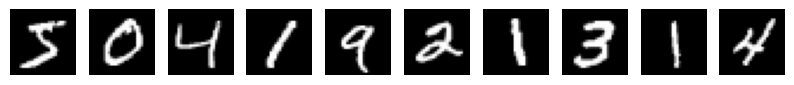

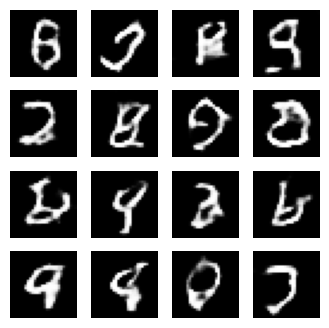

In [9]:
if __name__ == "__main__":
    train_dcgan_mnist()